In [ ]:
import tensorflow as tf

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import sklearn.linear_model as lm
logreg = lm.LogisticRegression(multi_class='multinomial', solver='lbfgs')
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack

import os
from functools import partial
from collections import namedtuple
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.9.1


In [ ]:
pip install tensorflow

In [ ]:
# Defining the path for train and test images


data_dir_train = pathlib.Path("C:/Users/Documents/lung_image_sets/Train")
data_dir_test = pathlib.Path('C:/Users/Documents/lung_image_sets/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*')))
print(image_count_test)

14700
300


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14700 files belonging to 3 classes.
Using 11760 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [ ]:
# List out all the classes of cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['lung_aca', 'lung_n', 'lung_scc']


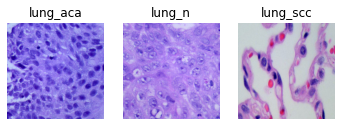

In [ ]:
import matplotlib.pyplot as plt

### visualize training or validation data to 
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(10):
  for i in range(3):
    ax = plt.subplot(3,5, i+1)
    plt.imshow(images[i].numpy().astype("int64"))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:

image_size = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255)
  #layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])

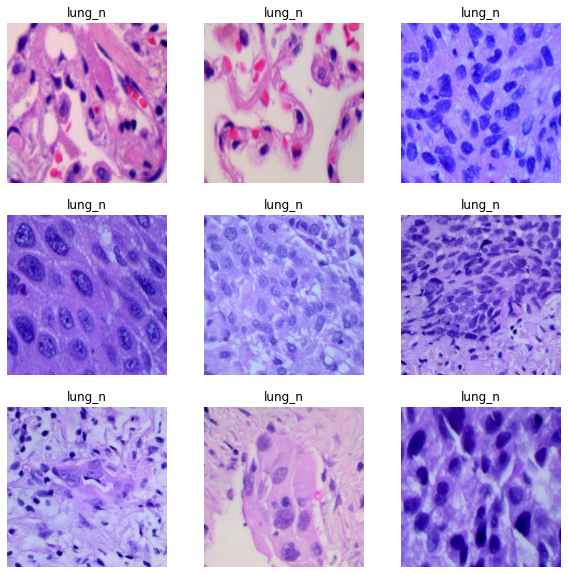

In [ ]:
train_ds.take(1)
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    
    plt.imshow(resize_and_rescale(images[i].numpy().astype("int64")))
    plt.title(class_names[1])
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
368/368 [==============================] - 162s 438ms/step - loss: 13.7547 - accuracy: 0.8139 - val_loss: 0.3331 - val_accuracy: 0.8667
Epoch 2/5
368/368 [==============================] - 149s 406ms/step - loss: 0.4103 - accuracy: 0.8176 - val_loss: 0.2785 - val_accuracy: 0.9167
Epoch 3/5
368/368 [==============================] - 152s 412ms/step - loss: 0.3765 - accuracy: 0.8344 - val_loss: 0.2305 - val_accuracy: 0.9167
Epoch 4/5
368/368 [==============================] - 140s 381ms/step - loss: 0.3324 - accuracy: 0.8660 - val_loss: 0.3001 - val_accuracy: 0.8667
Epoch 5/5
368/368 [==============================] - 130s 353ms/step - loss: 1.8664 - accuracy: 0.8484 - val_loss: 0.6255 - val_accuracy: 0.6167


In [ ]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

2/2 [==============================] - 0s 73ms/step - loss: 0.6255 - accuracy: 0.6167
Accuracy 0.6166666746139526


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)      

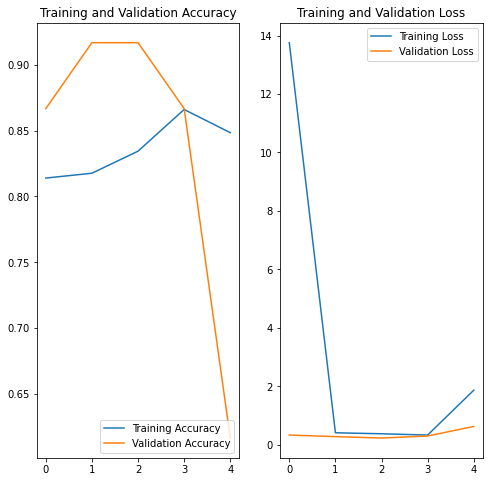

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Let's apply Augmentation Techniques

In [ ]:
# After we have analysed the model fit history for presence of underfit or overfit, 
#we will choose an appropriate data augumentation strategy. 


data_augmentation = tf.keras.Sequential([
  #layers.experimental.preprocessing.RandomFlip("horizontal"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
                                                 
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1)
  
])

#### Visualize few augmented examples how do they look like by applying data augmentation to the same image several times:
I will use data augmentation to train the model.

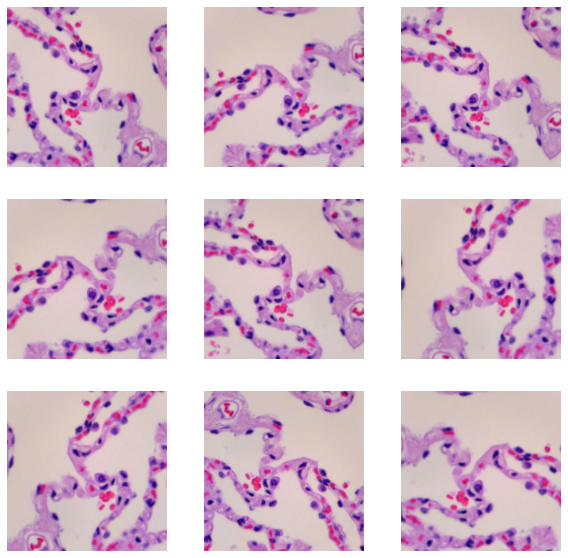

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(4):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
image, label = next(iter(train_ds))

In [ ]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

#### Create the model, compile and train the model

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
368/368 [==============================] - 166s 442ms/step - loss: 0.4108 - accuracy: 0.8094 - val_loss: 0.2766 - val_accuracy: 0.8500
Epoch 2/20
368/368 [==============================] - 168s 457ms/step - loss: 0.2207 - accuracy: 0.9117 - val_loss: 0.1998 - val_accuracy: 0.9167
Epoch 3/20
368/368 [==============================] - 173s 469ms/step - loss: 0.1733 - accuracy: 0.9310 - val_loss: 0.2117 - val_accuracy: 0.9000
Epoch 4/20
368/368 [==============================] - 175s 476ms/step - loss: 0.1466 - accuracy: 0.9439 - val_loss: 0.1589 - val_accuracy: 0.9167
Epoch 5/20
368/368 [==============================] - 3585s 10s/step - loss: 0.1364 - accuracy: 0.9465 - val_loss: 0.1323 - val_accuracy: 0.9333
Epoch 6/20
368/368 [==============================] - 146s 396ms/step - loss: 0.1310 - accuracy: 0.9484 - val_loss: 0.1183 - val_accuracy: 0.9500
Epoch 7/20
368/368 [==============================] - 167s 455ms/step - loss: 0.1182 - accuracy: 0.9545 - val_loss: 0.0829 - 

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### Visualizing Results

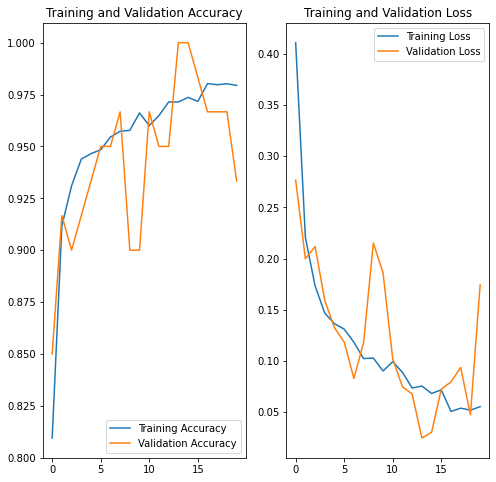

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

2/2 [==============================] - 0s 104ms/step - loss: 0.1742 - accuracy: 0.9333
Accuracy 0.9333333373069763
